## Model Creation

I use VGG16 pretrained model. VGG-16 is a trained Convolutional Neural Network (CNN), from Visual Geometry Group (VGG), Department of Engineering Science, University of Oxford. The number 16 means the number of layers with trainable weights.

#### Dataset

We have 4000 total labeled sample images in total to work with. That means 2000 fire images and 2000 non-fire images. Among them I have used 3000 images for training and 1000 for testing equally splitting among both the labels.


#### Importing Required Packages

In [1]:
import os                                     # operating system 
import numpy as np                            # linear algebra 
from PIL import Image                         # Python image library 
from tensorflow import keras
from keras import optimizers

import matplotlib.pyplot as plt               # making plots
%matplotlib inline 
from IPython.display import display           # displaying ?

import warnings                               # ignoring unnecessary python warnings 
warnings.filterwarnings('ignore')

from keras.applications.vgg16 import VGG16                    # pretrained CNN                        
from keras.callbacks import ModelCheckpoint                  # furter train the saved model 
from keras import models, layers, optimizers                 # building DNN is keras 
from tensorflow.keras.models import load_model               # load saved model 
from keras.preprocessing.image import ImageDataGenerator 

## Setting Up of Model

Loss: Since this is classification problem and there are two classes, we use the binary cross-entropy as the loss function.

Optimizer: We use RMSprop optimizer with customized learning rate.

Metrics: In addition to the loss we want to observe the accuracy. We optimize our model based on this metric.

In [2]:
conv_base = VGG16(weights='imagenet', 
                 include_top=False,
                 input_shape=(150, 150, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

conv_base.trainable = False

model.compile(loss='binary_crossentropy', 
             optimizer=keras.optimizers.RMSprop(learning_rate=0.01), 
             metrics=['acc'])

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


## Preparation of Data

Calling Test and train dataset directory which we previously created.

In [4]:
base_dir = 'C:/Users/veera/VGG_16'

train_dir = os.path.join(base_dir, 'train')
train_dir_fire = os.path.join(train_dir, 'fire')
train_dir_nofire = os.path.join(train_dir, 'nofire')

test_dir = os.path.join(base_dir, 'test')
test_dir_fire = os.path.join(test_dir, 'fire')
test_dir_nofire = os.path.join(test_dir, 'nofire')

#### Data generator & data augmentation

For the large dataset it is not convenient to load all the data into memory. So we use image data generator to load the data from hard disc to memory in small batch for both training and test dataset.

Further, when initiating the image data generator we can do the data augmentation. This is the step to create more data from existing data by transforming the image. This artificially provides more data to train. Here we use rotation, translation, shear, zooming and horizontal flip for data augmentation.Data Augmentation is donle only on training dataset.

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                   target_size=(150, 150), 
                                                   batch_size=32,
                                                   class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir, 
                                                   target_size=(150, 150), 
                                                   batch_size=32,
                                                   class_mode='binary')

Found 3853 images belonging to 2 classes.
Found 3072 images belonging to 2 classes.


## Training of model
Training of the model is done for 30 epochs using training data from train_generator. Validation is done using data from test_generator and got an accuracy over 91%.

In [9]:
history = model.fit(train_generator, epochs=30, 
                    validation_data=test_generator)

Epoch 1/30
121/121 [==============================] - 462s 4s/step - loss: 0.2633 - acc: 0.8920 - val_loss: 0.1948 - val_acc: 0.9313
Epoch 2/30
121/121 [==============================] - 469s 4s/step - loss: 0.2382 - acc: 0.9053 - val_loss: 0.2766 - val_acc: 0.9141
Epoch 3/30
121/121 [==============================] - 473s 4s/step - loss: 0.2727 - acc: 0.8918 - val_loss: 0.1829 - val_acc: 0.9349
Epoch 4/30
121/121 [==============================] - 473s 4s/step - loss: 0.2479 - acc: 0.9029 - val_loss: 0.3517 - val_acc: 0.8841
Epoch 5/30
121/121 [==============================] - 475s 4s/step - loss: 0.2471 - acc: 0.9060 - val_loss: 0.3036 - val_acc: 0.9098
Epoch 6/30
121/121 [==============================] - 474s 4s/step - loss: 0.2336 - acc: 0.9060 - val_loss: 0.2957 - val_acc: 0.9030
Epoch 7/30
121/121 [==============================] - 529s 4s/step - loss: 0.2615 - acc: 0.8944 - val_loss: 0.3339 - val_acc: 0.8848
Epoch 8/30
121/121 [==============================] - 486s 4s/step - 

Saving the trained model.

In [10]:
model.save('VGG16_fine_tuned.h5')

## Visualization of the model

Training gives four sets of values in each eopch

-Training accuracy
-Validation accuracy
-Training loss
-Validation loss

In [11]:
# Dictionary to extract the numbers 
hist_dict = history.history

# Training and validation accuracy 
training_acc = hist_dict['acc']
validation_acc = hist_dict['val_acc']

# Training and validation loss 
training_loss = hist_dict['loss']
validation_loss = hist_dict['val_loss']

# Number of epochs 
epoches = range(1, 1 + len(training_acc))

#### Function To make Plot

In [12]:
def plot_func(entity):
    
    '''
    This function produces plot to compare the performance 
    between train set and validation set. 
    entity can be loss of accuracy. 
    '''
    
    plt.figure(figsize=(8, 5))
    plt.plot(epoches, eval('training_' + entity), 'r')
    plt.plot(epoches, eval('validation_' + entity), 'b')
    plt.legend(['Training ' + entity, 'Validation ' + entity])
    plt.xlabel('Epoches')
    plt.ylabel(entity)
    plt.show()

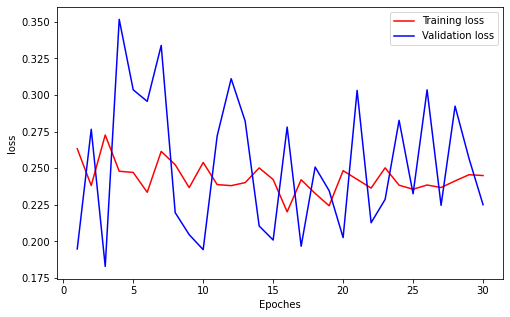

In [15]:
plot_func('loss')

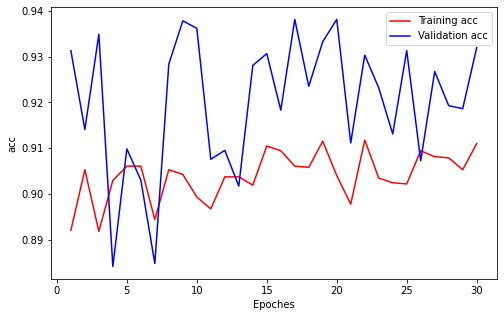

In [16]:
plot_func('acc')

## Classification By the model

In [17]:
# Loading the saved model 
model = load_model('VGG16_fine_tuned.h5')

In [18]:
# taking first batch from the generator 
img, label = test_generator[0] 

# Predicting the images from the first batch 
pred = np.round(model.predict(img)).flatten()

In [19]:
len(img)

32

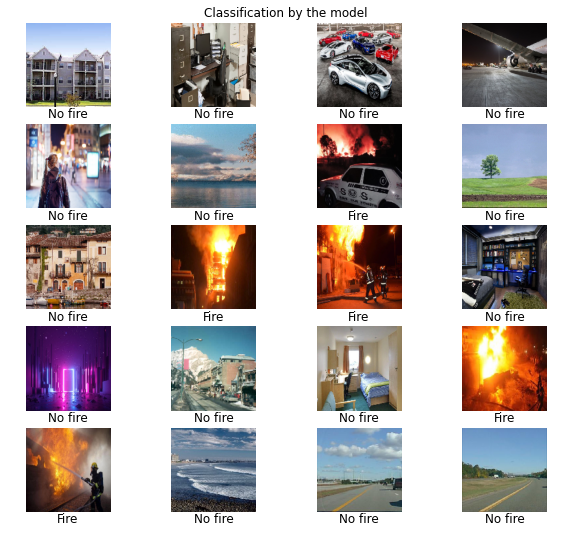

In [45]:
# Numeric to semantic labels 
label_dict = {1.0: 'No fire', 0.0: 'Fire'}

# Generating collage of plots 
fig = plt.figure(figsize=(10, 9))
plt.title('Classification by the model')
plt.axis('off')

for i, img_i in enumerate(img[:20]):
    ax = fig.add_subplot(5, 4, i+1)
    plt.axis('off')
    plt.title(label_dict[pred[i]], y=-0.2)
    ax.imshow(img_i)

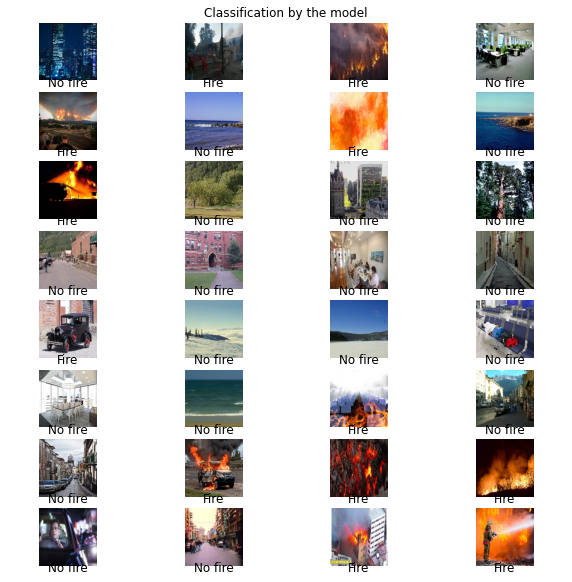

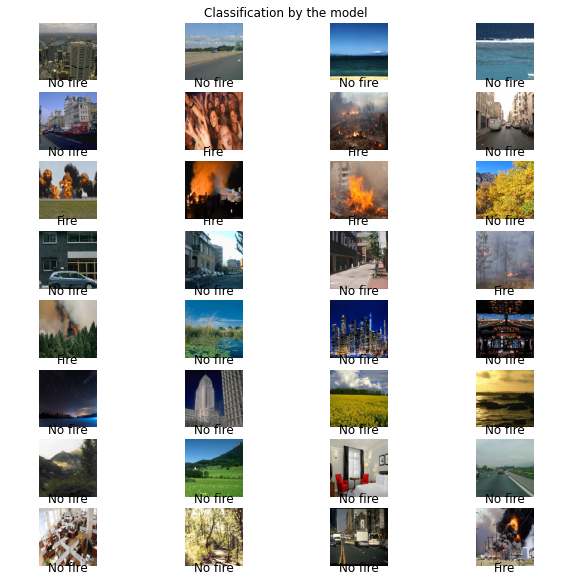

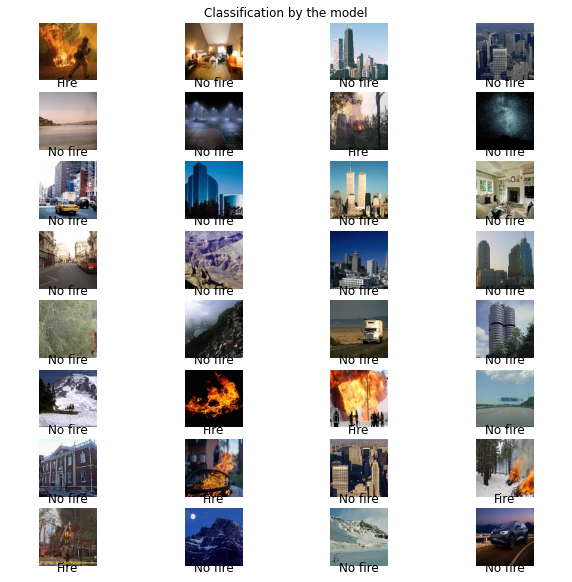

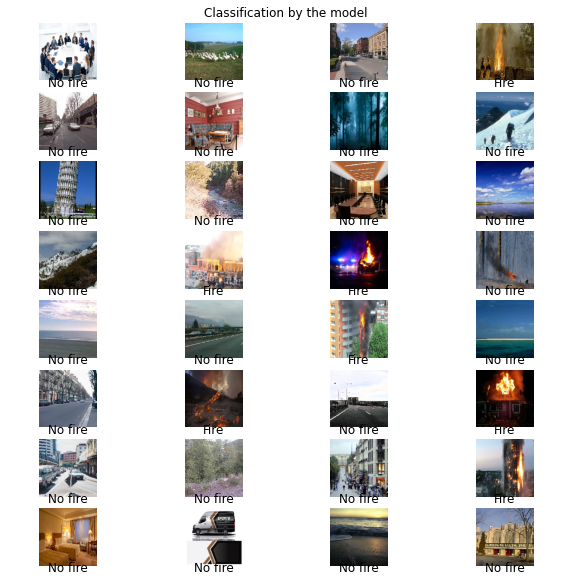

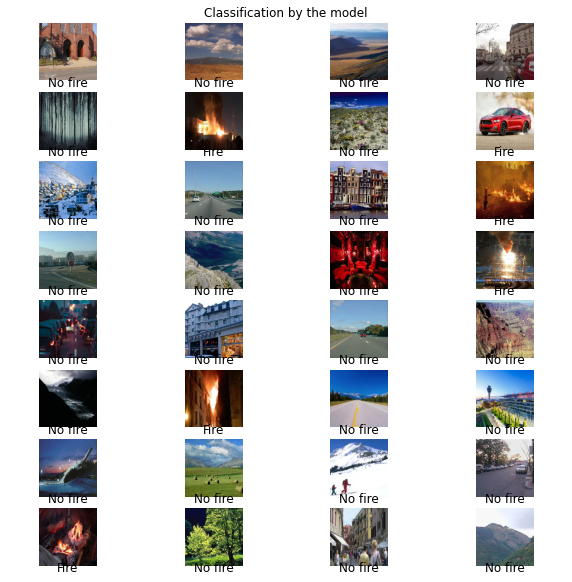

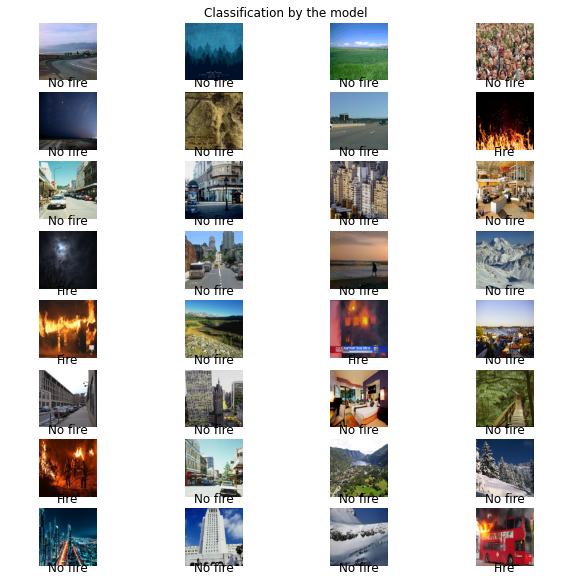

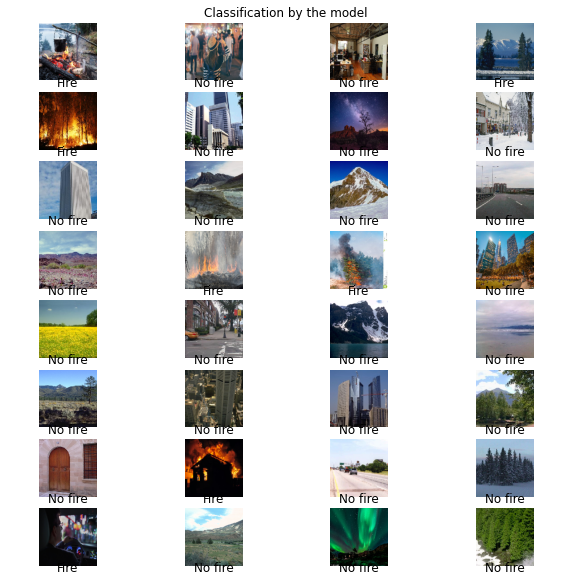

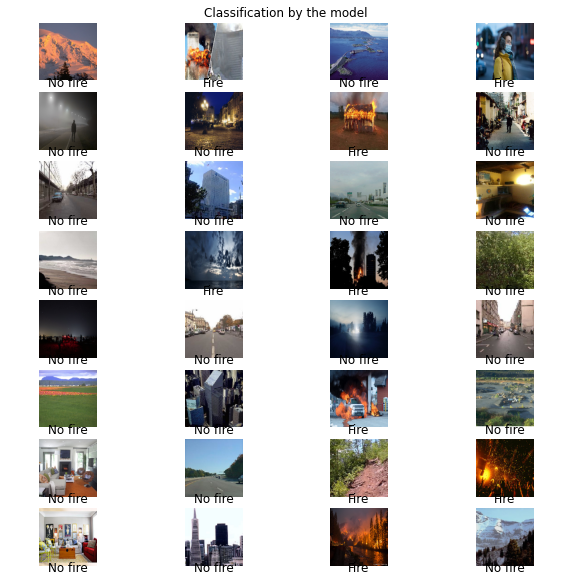

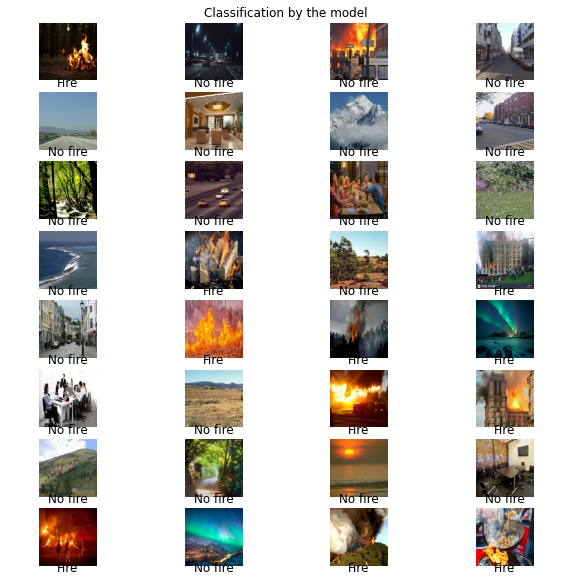

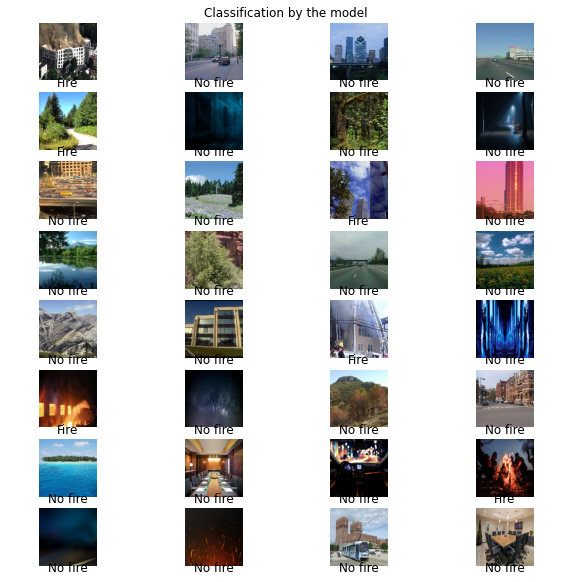

In [64]:
# taking first batch from the generator 
for x in range (10):
    img, label = test_generator [x]

    # Predicting the images from the first batch 
    pred = np.round(model.predict(img)).flatten()
    # Numeric to semantic labels 
    label_dict = {1.0: 'No fire', 0.0: 'Fire'}

    # Generating collage of plots 
    fig = plt.figure(figsize=(10, 10))
    plt.title('Classification by the model')
    plt.axis('off')

    for i, img_i in enumerate(img[:32]):
        ax = fig.add_subplot(8, 4, i+1)
        plt.axis('off')
        plt.title(label_dict[pred[i]], y=-0.2)
        ax.imshow(img_i)

## Error Analysis

In [24]:
# Lists for missed fire images and missed non-fire images
msd_fire = []
msd_nofire = []

# Iterating through all the batches 
for j in range(31):
    img, label = test_generator[j] 
    pred = np.round(model.predict(img)).flatten()
    bool_list = label == pred

    # bool_list is False when there is misclassification 
    for i, e in enumerate(bool_list):
        if e == False:
            
            # separating labels (fire and non-fire)
            if label[i] == 0:
                msd_fire.append(img[i])
            else:
                msd_nofire.append(img[i])

####  Confusion Matrix

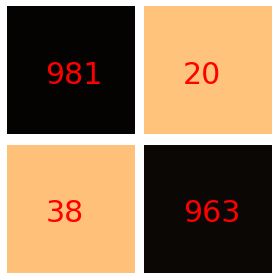

In [25]:
# total number of sample in train set in each class 
n_class = 1001

# number of misclassified fire and non-fire images 
nm_fire, nm_nofire = len(msd_fire), len(msd_nofire)

# confusion matrix (flattened)
conf_mat = [n_class-nm_fire, nm_fire, nm_nofire, n_class-nm_nofire]

# visualization of confusion matrix 
fig = plt.figure(figsize=(4, 4))
for i, j in enumerate(conf_mat):
    ax = fig.add_subplot(2, 2, i+1)
    ax.imshow([[j]], vmin=0, vmax=1000, cmap='copper_r')
    ax.text(-0.2, 0.1, j, c='r', fontsize=30)
    ax.axis('off')

# bringing blocks tighter 
fig.tight_layout()
fig.show()

#### Mis-Classified Images

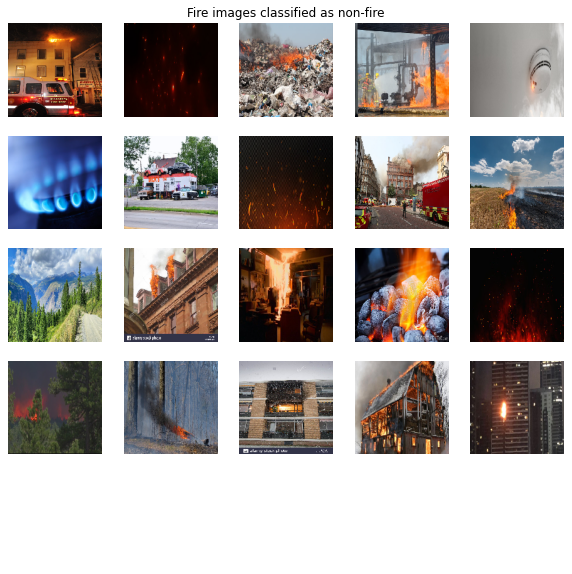

In [37]:
fig = plt.figure(figsize=(10, 10))
plt.title('Fire images classified as non-fire')
plt.axis('off')
for i, img_i in enumerate(msd_fire):        
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(img_i)
    ax.axis('off')

ValueError: num must be 1 <= num <= 25, not 26

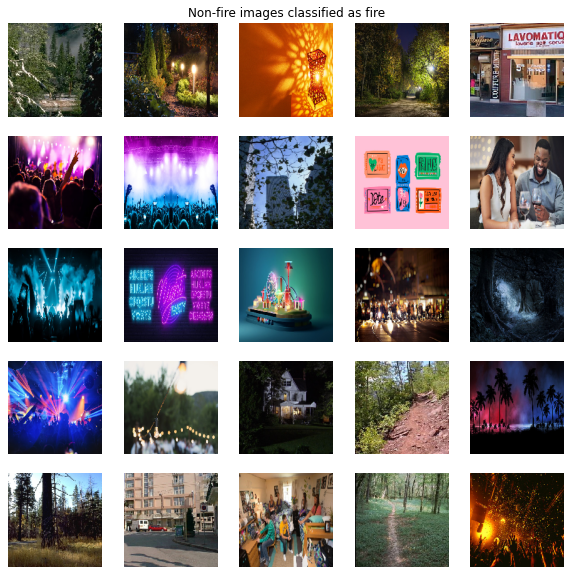

In [41]:
fig = plt.figure(figsize=(10, 10))
plt.title('Non-fire images classified as fire')
plt.axis('off')
for i, img_i in enumerate(msd_nofire):        
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(img_i)
    ax.axis('off')

In [46]:
base_dir = 'C:/Users/veera/VGG_16'

result_dir=os.path.join(base_dir, 'result')

result_dir_fire = os.path.join(result_dir, 'fire')
if not os.path.exists(result_dir_fire):
    os.makedirs(result_dir_fire)

result_dir_nofire = os.path.join(result_dir, 'nofire')
if not os.path.exists(result_dir_nofire):
    os.makedirs(result_dir_nofire)
